# Code

In [4]:
%pip install PyGithub python-dotenv pandas tqdm matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime


In [6]:
ORGANIZATIONS = ["googlesamples", "aws-samples", "Azure-Samples", "spring-guides", "googlearchive", "spring-cloud-samples"]
# ORGANIZATIONS = ["googlesamples"]
EXCLUDED_REPOS = [
    "googlearchive/digits-migration-helper-android",
    "googlearchive/play-apk-expansion",
    "googlearchive/tiger",
    "googlearchive/two-token-sw",
    "googlearchive/Abelana-Android",
    "googlearchive/solutions-mobile-backend-starter-java"
]

In [7]:
load_dotenv()
github_client = Github(getenv('GITHUB_TOKEN'), per_page=100)

In [8]:
def fetch_organization_repositories(organization_name, language=None):
    organization = github_client.get_organization(organization_name)
    repositories = organization.get_repos("all")
    total_repositories = repositories.totalCount
    repo_data = []

    def process_repo(repo):
        if repo.full_name in EXCLUDED_REPOS:
            return None

        if organization_name == "googlearchive" and not is_valid_googlearchive_repo(repo):
            return None
        elif organization_name == "SAP-samples" and not is_valid_sap_sample_repo(repo):
            return None

        repo_languages = repo.get_languages()
        total_lines = sum(repo_languages.values())
        language_percentages = {lang: f'{(lines/total_lines):.2%}' for lang, lines in repo_languages.items()}
        return {
            "full_name": repo.full_name,
            "name": repo.name,
            "owner": repo.owner.login,
            "html_url": repo.html_url,
            "description": repo.description,
            "language": repo.language,
            "created_at": repo.created_at,
            "updated_at": repo.updated_at,
            "pushed_at": repo.pushed_at,
            "size": repo.size,
            "stargazers_count": repo.stargazers_count,
            "watchers_count": repo.watchers_count,
            "forks_count": repo.forks_count,
            "open_issues_count": repo.open_issues_count,
            "subscribers_count": repo.subscribers_count,
            "network_count": repo.network_count,
            "archived": repo.archived,
            "total_lines": total_lines,
            "langs_percentage": language_percentages
        }

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_repo, repo) for repo in repositories]
        for future in tqdm(as_completed(futures), desc=organization_name, unit=" repos", total=total_repositories, ncols=100):
            result = future.result()
            if result:
                repo_data.append(result)
                
    return pd.DataFrame(repo_data)

def is_valid_googlearchive_repo(repo):
    if not repo.description:
        return False
    keywords = ["example", "sample", "migrated"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)

def is_valid_sap_sample_repo(repo):
    if not repo.description:
        return False
    keywords = ["cloud"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)


In [9]:
def generate_metrics_csv():
    all_repos_data = []
    
    def fetch_data_for_organization(organization):
        print(f'Retrieving repos from {organization}...')
        organization_repos_data = fetch_organization_repositories(organization)
        if not organization_repos_data.empty:
            return organization_repos_data
        else:
            return pd.DataFrame()

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_data_for_organization, org) for org in ORGANIZATIONS]
        for future in tqdm(as_completed(futures), desc="Processing organizations", unit=" orgs"):
            org_data = future.result()
            if not org_data.empty:
                all_repos_data.append(org_data)

    all_repos_data_df = pd.concat(all_repos_data, ignore_index=True) if all_repos_data else pd.DataFrame()
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_path = f"results/codesamples_{timestamp}.csv"
    all_repos_data_df.to_csv(file_path, index=False)

    return all_repos_data_df

In [10]:
def calculate_language_usage(dataframe):
    language_usage = {}

    for repo in dataframe.itertuples():
        repo_languages = repo.langs_percentage
        total_lines = repo.total_lines

        for language, percentage in repo_languages.items():
            lines = total_lines * (float(percentage.strip('%')) / 100)
            language_usage[language] = language_usage.get(language, 0) + lines

    total_lines_of_code = sum(language_usage.values())

    formatted_languages = sorted(
        [(language, f'{(lines / total_lines_of_code):.2%}', int(lines)) for language, lines in language_usage.items()],
        key=lambda item: float(item[1].strip('%')),
        reverse=True
    )

    file_path = f"results/languages_usage.csv"
    dataframeLanguages = pd.DataFrame(formatted_languages, columns=["Language", "Usage Percentage", "Lines"])
    dataframeLanguages.to_csv(file_path, index=False)
    return dataframeLanguages


In [11]:
def generate_statistics(dataframe):
    numeric_metrics = dataframe[METRICS].select_dtypes(include='number')
    
    statistics = numeric_metrics.describe().transpose()
    
    statistics['median'] = numeric_metrics.median()
    statistics['mode'] = numeric_metrics.mode().iloc[0]
    
    file_path = f"results/statistics.csv"
    statistics.to_csv(file_path)
    
    return statistics

In [34]:
def plot_metrics_distribution(metricts):
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metricts):
        plt.subplot(3, 3, i + 1)
        sns.histplot(dataframe[metric], kde=True, bins=30, color='blue', alpha=0.6)
        plt.axvline(dataframe[metric].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(dataframe[metric].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.savefig('results/distribution_metrics.png')
    plt.show()

In [36]:
def plot_metrics_boxplot(metricts):
    numeric_metrics = dataframe[metricts].select_dtypes(include='number')
    
    plt.figure(figsize=(16, 12))
    for i, metric in enumerate(numeric_metrics.columns):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(x=numeric_metrics[metric], color='lightblue')
        plt.title(f'Boxplot of {metric}')
        plt.xlabel(metric)
    
    plt.tight_layout()
    plt.savefig('results/boxplot_metrics.png')
    plt.show()

In [38]:
def plot_metrics_statistics(metricts):
    desc_stats = dataframe[metricts].describe().T[['mean', '50%', 'std']]
    desc_stats.columns = ['Mean', 'Median', 'Standard Deviation']
    desc_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('Descriptive Statistics of Repository Metrics')
    plt.ylabel('Values')
    plt.xticks(rotation=0)
    plt.savefig('results/metrics_statistics.png')
    plt.show()

# Results

In [32]:
METRICS = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines'
]

In [16]:
dataframe = generate_metrics_csv()
dataframe

Retrieving repos from googlesamples...
Retrieving repos from aws-samples...
Retrieving repos from Azure-Samples...
Retrieving repos from spring-guides...
Retrieving repos from googlearchive...
Retrieving repos from spring-cloud-samples...


Processing organizations: 0 orgs [00:00, ? orgs/s]



spring-cloud-samples: 100%|█████████████████████████████████████| 29/29 [00:04<00:00,  7.11 repos/s]

Processing organizations: 1 orgs [00:06,  6.43s/ orgs]





spring-guides: 100%|████████████████████████████████████████████| 74/74 [00:02<00:00, 28.54 repos/s]
Processing organizations: 3 orgs [00:09,  2.46s/ orgs]Request GET /repos/Azure-Samples/application-gateway-java-manage-simple-application-gateways/languages failed with 403: Forbidden
Retrying after 60 seconds
Request GET /repos/aws-samples/amazon-gamelift-unity/languages failed with 403: Forbidden
Retrying after 60 seconds
Request GET /repos/aws-samples/amazon-cloudwatch-percentiles-high-volume-data-monitoring failed with 403: Forbidden
Retrying after 60 seconds
Request GET /repos/aws-samples/aws-appsync-calorie-tracker-workshop/languages failed with 403: Forbidden
Retrying after 60 seconds
Request GET /repos/aws-samples/aws-cloudformation-advanced-reinvent-2018 failed with 403: Forbidden
Retrying after 60 seconds
Request GE

,full_name,name,owner,html_url,description,language,created_at,updated_at,pushed_at,size,stargazers_count,watchers_count,forks_count,open_issues_count,subscribers_count,network_count,archived,total_lines,langs_percentage
0,spring-cloud-samples/spring-cloud-gateway-sample,spring-cloud-gateway-sample,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,Sample Spring Cloud Gateway Application,Java,2017-10-13 16:41:13+00:00,2024-07-27 06:24:56+00:00,2021-12-07 20:03:34+00:00,79,360,360,231,16,15,231,False,5990,{'Java': '100.00%'}
1,spring-cloud-samples/spring-cloud-contract-nod...,spring-cloud-contract-nodejs-external-contracts,spring-cloud-samples,https://github.com/spring-cloud-samples/spring...,External contracts for the Spring Cloud Contra...,Java,2018-03-15 15:42:55+00:00,2021-04-26 15:04:54+00:00,2021-04-26 15:04:51+00:00,60,1,1,4,1,3,4,False,3798,{'Java': '100.00%'}
2,spring-cloud-samples/eureka,eureka,spring-cloud-samples,https://github.com/spring-cloud-samples/eureka,None,Java,2014-07-20 16:23:11+00:00,2024-07-31 17:49:29+00:00,2024-06-09 16:22:42+00:00,995,498,498,432,8,36,432,False,1550,{'Java': '100.00%'}
3,spring-cloud-samples/sleuth-issues,sleuth-issues,spring-cloud-samples,https://github.com/spring-cloud-samples/sleuth...,Samples for Sleuth that replicate issues,Java,2018-04-20 15:04:26+00:00,2024-08-01 04:59:28+00:00,2024-08-01 05:00:03+00:00,637,2,2,5,5,6,5,False,63827,"{'Java': '92.24%', 'Groovy': '7.32%', 'Shell':..."
4,spring-cloud-samples/brewery-config,brewery-config,spring-cloud-samples,https://github.com/spring-cloud-samples/brewer...,Configuration for the Brewery,None,2016-02-23 13:32:01+00:00,2021-04-26 15:03:01+00:00,2021-04-26 15:02:59+00:00,0,0,0,8,0,4,8,False,0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9306,aws-samples/rds-cross-region-snapshot,rds-cross-region-snapshot,aws-samples,https://github.com/aws-samples/rds-cross-regio...,None,None,2024-08-01 07:25:04+00:00,2024-08-02 03:01:50+00:00,2024-08-01 12:25:26+00:00,218,1,1,0,0,1,0,False,0,{}
9307,aws-samples/deploy-langfuse-on-ecs-with-fargate,deploy-langfuse-on-ecs-with-fargate,aws-samples,https://github.com/aws-samples/deploy-langfuse...,Hosting Langfuse on Amazon ECS with Fargate us...,Python,2024-08-01 23:14:45+00:00,2024-08-05 13:37:41+00:00,2024-08-05 13:37:37+00:00,770,7,7,2,0,2,2,False,18834,"{'Python': '97.68%', 'Batchfile': '2.32%'}"
9308,aws-samples/build-an-event-driven-knowledge-gr...,build-an-event-driven-knowledge-graph-with-mac...,aws-samples,https://github.com/aws-samples/build-an-event-...,This sample-code demonstrates how to build an ...,Python,2024-08-01 09:38:16+00:00,2024-08-06 12:22:24+00:00,2024-08-06 10:46:05+00:00,29,0,0,0,0,0,0,False,72312,"{'Python': '74.50%', 'Jupyter Notebook': '25.5..."
9309,aws-samples/generative-ai-applications-foundat...,generative-ai-applications-foundational-archit...,aws-samples,https://github.com/aws-samples/generative-ai-a...,None,Python,2024-08-02 05:27:37+00:00,2024-08-06 08:10:47+00:00,2024-08-03 01:39:02+00:00,9335,2,2,0,2,1,0,False,470467,"{'Python': '66.12%', 'TypeScript': '13.47%', '..."


In [17]:
dataframeLanguages = calculate_language_usage(dataframe)
dataframeLanguages

,Language,Usage Percentage,Lines
0,Jupyter Notebook,32.59%,975652920
1,Python,23.91%,715823604
2,C,12.38%,370639616
3,JavaScript,7.01%,209812092
4,HTML,5.31%,158879511
...,...,...,...
144,SmPL,0.00%,0
145,ABAP,0.00%,52354
146,Astro,0.00%,4980
147,BitBake,0.00%,1122


In [18]:
dataframe_statistics = generate_statistics(dataframe)
dataframe_statistics

,count,mean,std,min,25%,50%,75%,max,median,mode
size,9311.0,8916.389432,4.769093e+04,0.0,64.0,407.0,2554.0,1965261.0,407.0,10
stargazers_count,9311.0,37.429170,1.913035e+02,0.0,2.0,6.0,19.0,9845.0,6.0,1
watchers_count,9311.0,37.429170,1.913035e+02,0.0,2.0,6.0,19.0,9845.0,6.0,1
forks_count,9311.0,30.290302,1.912473e+02,0.0,1.0,4.0,13.0,8306.0,4.0,0
open_issues_count,9311.0,2.908495,1.018360e+01,0.0,0.0,1.0,2.0,509.0,1.0,0
subscribers_count,9311.0,15.596821,6.575471e+01,0.0,3.0,8.0,17.0,4563.0,8.0,2
network_count,9311.0,36.597251,3.961190e+02,0.0,1.0,4.0,13.0,23215.0,4.0,0
total_lines,9311.0,321574.221244,3.356087e+06,0.0,7044.0,23902.0,83975.5,185625162.0,23902.0,0


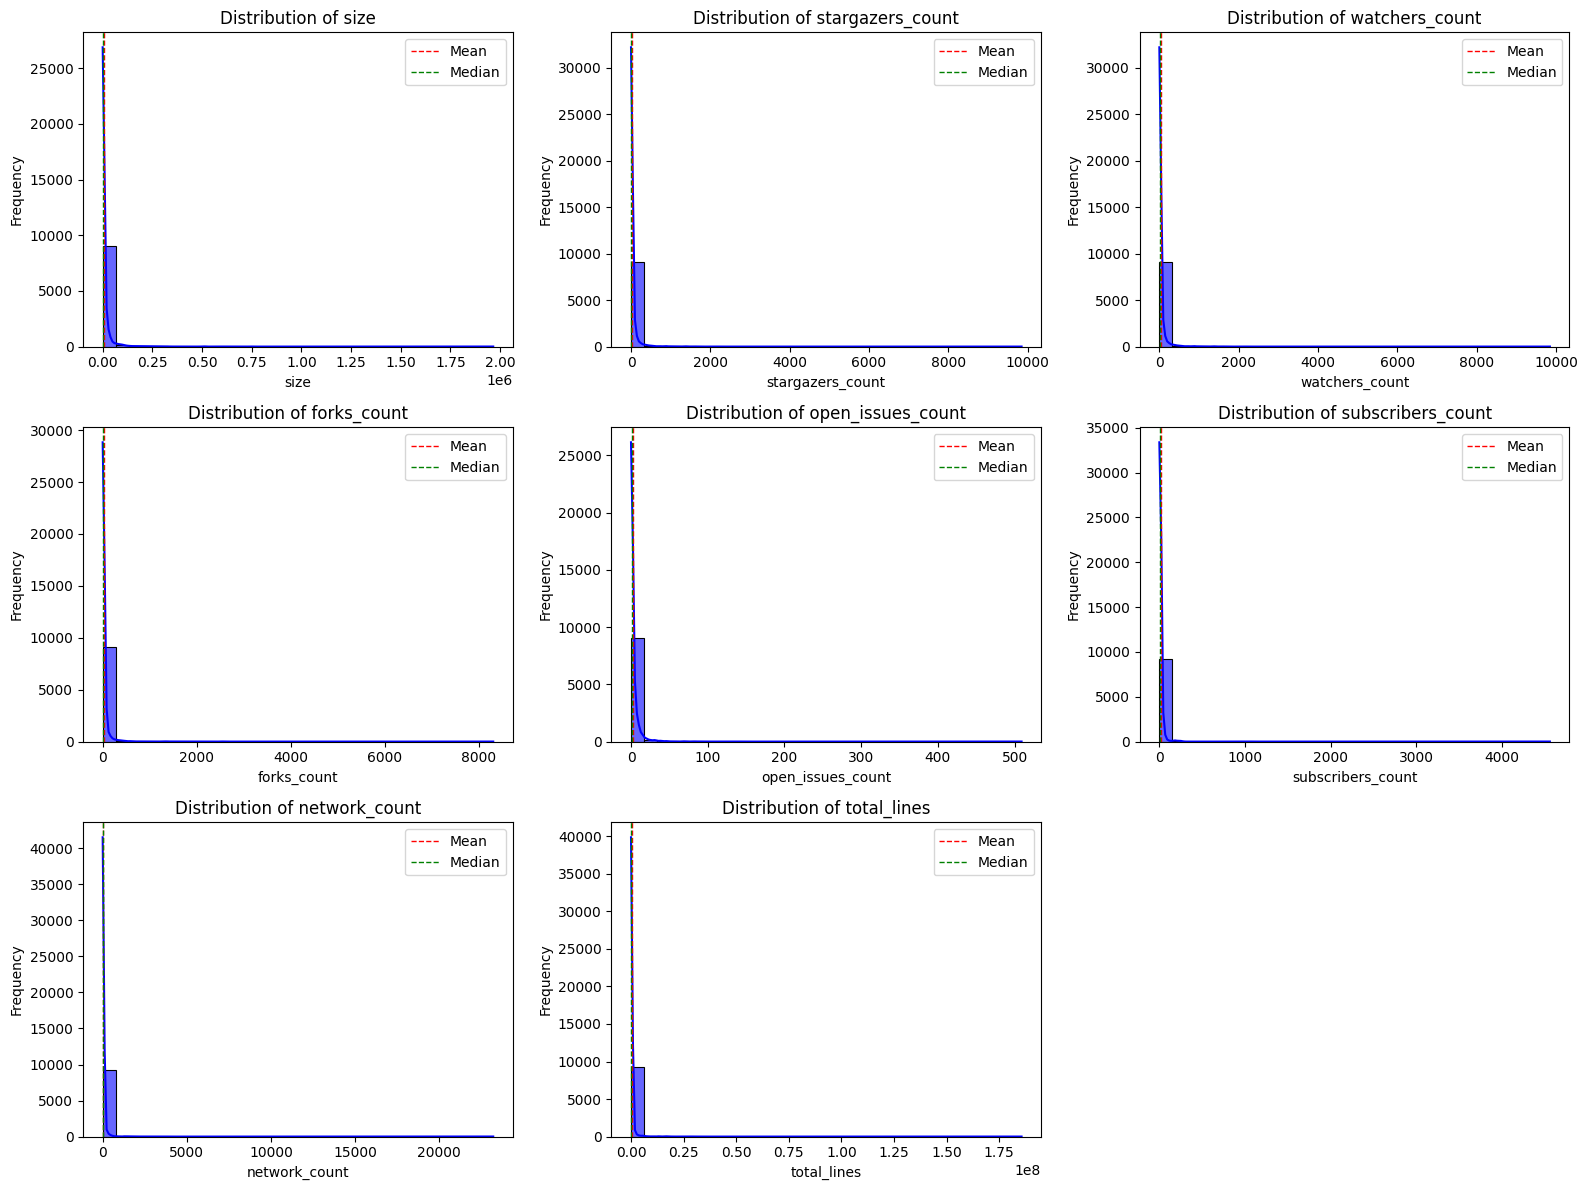

In [35]:
metricts = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines'
]
plot_metrics_distribution(metricts)

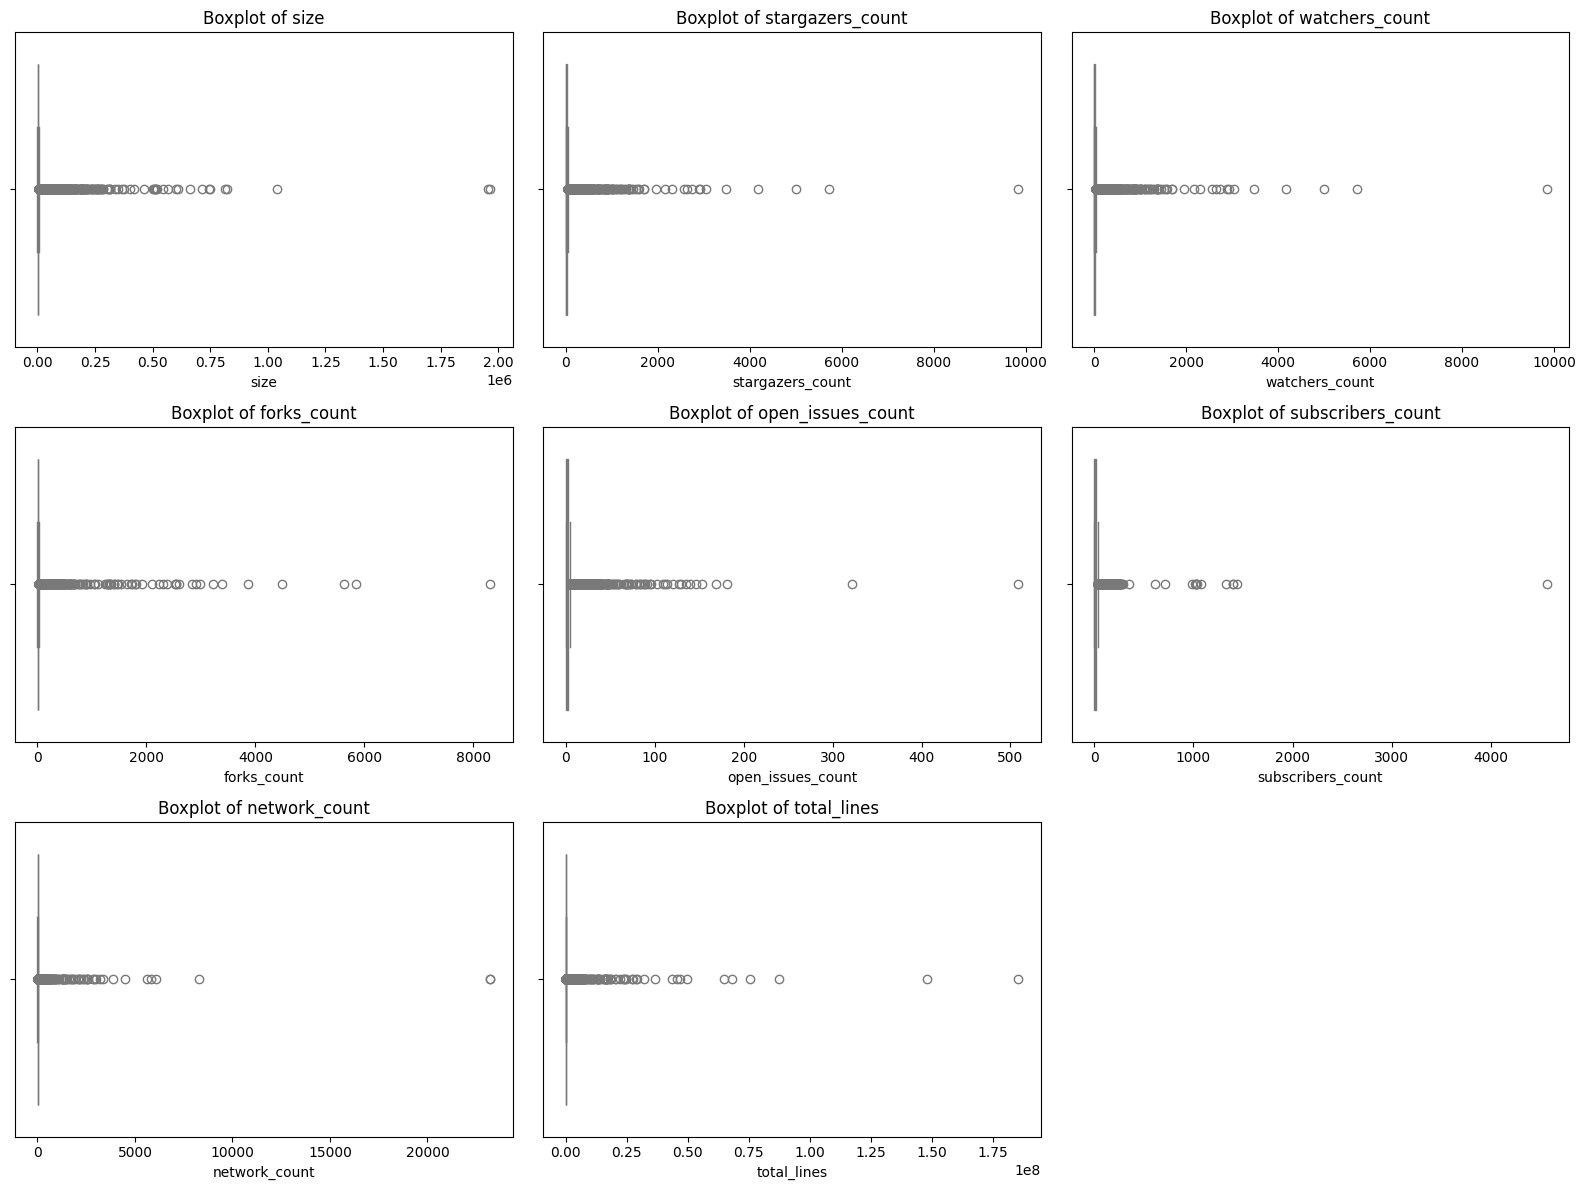

In [37]:
metricts = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
    'total_lines'
]
plot_metrics_boxplot(metricts)

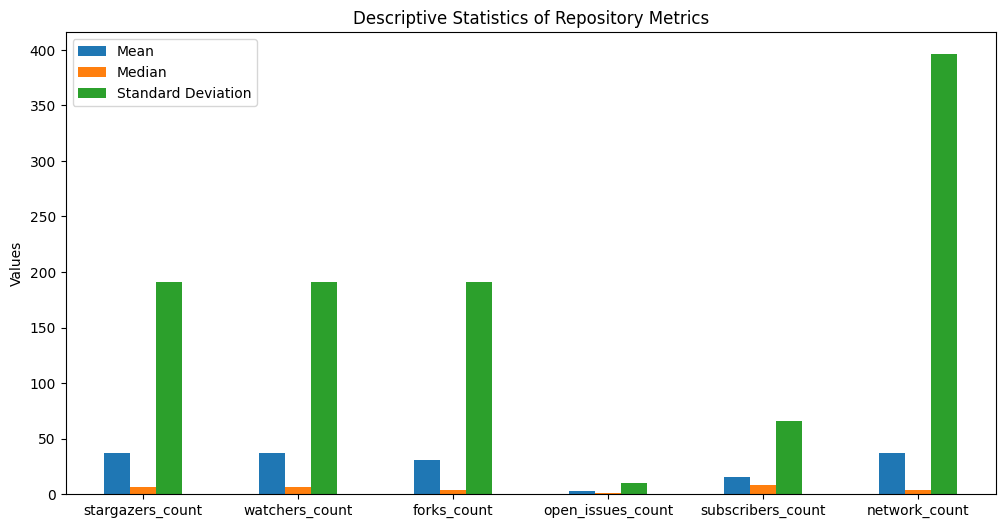

In [39]:
metricts = [
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count',
]
plot_metrics_statistics(metricts)